# Mapping Chemical Space with UMAP

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12uTTwDvfSUKK8g5iQ9mbEgX6kJnp9B30?usp=sharing)

**Content**:
1. Create 2D visualization of Blood Brain Barrier Permeability (BBBP) dataset with UMAP
2. Compare the UMAP embedding to PCA and T-SNE embeddings
3. Embed the dataset in a chemical dataset

**The dataset**:  
The BBBP (Blood-Brain Barrier Penetration) dataset from [MoleculeNet](https://moleculenet.org/datasets-1) contains information on molecules and their ability to penetrate the blood-brain barrier, which is crucial for drug discovery and development.

**The method**:  
The UMAP method is an example of *unsupervised* machine learning since the data is processed without knowing its label.

**Methodology**:
- This notebook has gaps that you have to fill. If all gaps are filled in correctly, the notebook can be run.
- A solution notebook with all gaps filled is provided in the GitHub repository.
- Gaps are marked with a `#TODO`

This notebook has been created being inspired by or using content from [Source Notebook on Google Colab](https://colab.research.google.com/gist/ElanaPearl/444b3331f61485bbe8862db27cb2b968/mapping-chemical-space-with-umap.ipynb#scrollTo=dzmJAwfiAi6k)

## 1. Import libraries and data
Here all necessary libraries are imported and the necessary data is fetched. Also helper functions are set up.

- `os`: Provides functions to interact with the operating system, such as checking file existence.
- `pandas`: Used for data manipulation and analysis.
- `numpy`: Provides support for numerical computations.
- `seaborn`: A visualization library based on matplotlib for statistical graphics.
- `matplotlib.pyplot`: A plotting library for creating static, animated, and interactive visualizations.
- `rdkit`: A toolkit for cheminformatics, used for handling chemical information.
- `sklearn`: A machine learning library for data analysis and modeling.
- `umap.umap_`: A library for dimensionality reduction using UMAP (Uniform Manifold Approximation and Projection).

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
import sklearn
import umap.umap_ as umap

from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

In [2]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [3]:
def get_largest_fragment_from_smiles(s: str):
    mol = rdkit.Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return rdkit.Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list):
    """ Computes ecfp descriptors """

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = rdkit.Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

Load data if neccesary (This is necessary in a google colab)

In [4]:
import urllib.request

if not os.path.exists('data/BBBP.csv'):
    url = "https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/BBBP.csv"
    urllib.request.urlretrieve(url, "data/BBBP.csv")
    print("Data loaded from URL and saved locally")

bbbp = pd.read_csv("data/BBBP.csv")
bbbp.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [5]:

if not os.path.exists('data/chembl_sparse.csv.gz'):
    url = "https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/chembl_sparse.csv.gz"
    urllib.request.urlretrieve(url, "data/chembl_sparse.csv.gz")
    print("Data loaded from URL and saved locally")

chembl = pd.read_csv("data/chembl_sparse.csv.gz", compression='gzip')
chembl.head()

,smiles,CHEMBL1075051,CHEMBL1075104,CHEMBL1075145,CHEMBL1075189,CHEMBL1075228,CHEMBL1075284,CHEMBL1075319,CHEMBL1163101,CHEMBL1163116,...,CHEMBL6084,CHEMBL6136,CHEMBL6137,CHEMBL6140,CHEMBL6141,CHEMBL6145,CHEMBL6154,CHEMBL6164,CHEMBL6166,CHEMBL6184
0,Oc1ccccc1\C=N\c2ccccc2\N=C\c3ccccc3O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C[C@@H](O)[C@H](NC(=O)CN(CCCNC(=N)N)NC(=O)[C@H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oc1cnc2[nH]c3cnc(cc3c2c1)C#N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,COc1c(C)c2COC(=O)c2c(O)c1CCOP(=O)(O)CCSc3nc4c(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C[C@H]1CN(CCCN(c2ccccc2)c3ccccc3)C[C@H](C)N1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Embed BBBP with UMAP, PCA, t-SNE (Dataset-Specific Embeddings)

### Read in and process data

In [6]:
# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()
pd.DataFrame(bbbp).head()

,smiles,permeable,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin


### Compute ECFP Descriptors
 embed your smiles as [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t)

In [7]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

### Embed with UMAP

In [8]:
%%time
umap_reducer = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
umap_embedding = umap_reducer.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = umap_embedding[:,0], umap_embedding[:,1]
pd.DataFrame(bbbp).head()

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: total: 50.5 s
Wall time: 46.2 s


,smiles,permeable,name,UMAP_0,UMAP_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,10.862103,10.971208
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.569584,11.358079
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,12.905377,8.768739
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,13.956489,11.256364
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,8.054931,3.295020


### Embed with PCA

In [9]:
%%time
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_0"], bbbp["PCA_1"] = X_pca[:,0], X_pca[:,1]
pd.DataFrame(bbbp).head()

CPU times: total: 500 ms
Wall time: 106 ms


,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,10.862103,10.971208,-0.884492,0.820430
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.569584,11.358079,-0.141910,0.399242
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,12.905377,8.768739,0.196480,-0.383867
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,13.956489,11.256364,-0.607410,-0.263474
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,8.054931,3.295020,0.121059,1.925563


### Embed with t-SNE

In [10]:
%%time
tsne = sklearn.manifold.TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_0"], bbbp["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]
pd.DataFrame(bbbp).head()

CPU times: total: 48 s
Wall time: 8.13 s


,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,10.862103,10.971208,-0.884492,0.820430,-30.161406,-0.858808
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,10.569584,11.358079,-0.141910,0.399242,-28.510588,-20.824064
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,12.905377,8.768739,0.196480,-0.383867,-19.042479,-47.864689
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,13.956489,11.256364,-0.607410,-0.263474,-39.639866,26.964922
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,8.054931,3.295020,0.121059,1.925563,-74.040260,-4.201618


### Visualize the dataset embeddedings

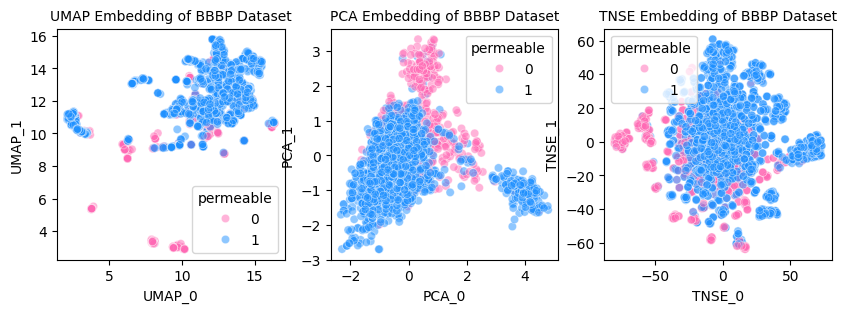

In [11]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i, method in enumerate(["UMAP", "PCA", "TNSE"]):
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette,
                    ax=ax[i])
    ax[i].set_title(f"{method} Embedding of BBBP Dataset", fontsize=10)